# Autoencoders (TensorFlow)

[![Open in Colab](https://lab.aef.me/files/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/lab/blob/main/files/tf/autoencoder.ipynb)
[![Open in Kaggle](https://lab.aef.me/files/assets/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/adamelliotfields/lab/blob/main/files/tf/autoencoder.ipynb)
[![Render nbviewer](https://lab.aef.me/files/assets/nbviewer_badge.svg)](https://nbviewer.org/github/adamelliotfields/lab/blob/main/files/tf/autoencoder.ipynb)

Autoencoder models include both an encoder and a decoder. More familiar encoder-decoder models like T5 generate output that is different from the input, while autoencoders aim to reconstruct the input from a compressed representation. Practical uses of autoencoders include denoising and anomaly detection.

The data used to train autoencoders is unlabeled, although this is considered _self-supervised_ rather than purely _unsupervised_. This is because the output is compared to the input (or an augmented version of the input) during training.

The model learns a compressed representation of the data known as the _latent space_ or _embedding_. The encoder learns to compress the input data into this space, while the decoder learns to reconstruct the input from this space. For example, a 28x28 black and white image (MNIST) would normally flatten to a 784-dimensional vector. The encoder would compress this down to a much smaller vector, like 32. This forces the model to learn only the most important features of the input. The decoder learns how to reconstruct images from the latent space.

This notebook demonstrates a convolutional autoencoder including:
* `Conv2D` and `SeparableConv2D` layers
* `Conv2DTranspose` and `UpSampling2D` layers
* with and without batch normalization (aka "BN-ReLU")
* reconstructing and denoising input

<figure>
  <img src="https://raw.githubusercontent.com/adamelliotfields/lab/main/files/assets/autoencoder.jpg" alt="Autoencoder diagram" />
  <figcaption>Source: <a href="https://blog.keras.io/building-autoencoders-in-keras.html" target="_blank" rel="noopener noreferrer">Keras</a>
</figure>

**Resources**
* [tensorflow.org/tutorials/generative/autoencoder](https://www.tensorflow.org/tutorials/generative/autoencoder)
* [blog.keras.io/building-autoencoders-in-keras](https://blog.keras.io/building-autoencoders-in-keras.html)
* [deeplearningbook.org/contents/autoencoders](https://www.deeplearningbook.org/contents/autoencoders.html)
* [ibm.com/topics/autoencoder](https://www.ibm.com/topics/autoencoder)

In [1]:
import os
from importlib.util import find_spec

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["KERAS_BACKEND"] = "tensorflow"

if find_spec("google.colab") is not None:
    os.environ["TFDS_DATA_DIR"] = "/content/drive/MyDrive/tensorflow_datasets"

In [ ]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    tpu = None
    strategy = tf.distribute.get_strategy()

In [2]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from keras import Input, Model, callbacks, layers, optimizers, saving

In [3]:
# !nvidia-smi --query-gpu=name,memory.total,memory.used,memory.free,utilization.gpu,utilization.memory --format=csv
for device in tf.config.list_logical_devices():
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [4]:
# @title Config
SEED = 42  # @param {type:"integer"}
EPOCHS = 10  # @param {type:"integer"}
VERBOSE = 1  # @param {type:"slider", min:0, max:1, step:1}
BATCH_SIZE = 128  # @param {type:"integer"}
MODEL_PATH = "/content/drive/MyDrive/autoencoder_mnist.model.keras"  # @param {type:"string"}

In [5]:
# @title Functions
def prepare_data(image, _):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, (28, 28, 1))
    return image, image


# because our data is now (image, image) pairs, we need to be able to "take" a single image for inference
def take_image(image, _):
    return image


# apply a noise factor to the image tensor
def noisy(image, factor=0.1):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=factor, dtype=tf.float32)
    image = image + noise
    return tf.clip_by_value(image, 0.0, 1.0)

In [6]:
# @title Data
(mnist_train, mnist_test), mnist_info = tfds.load(
    "mnist",
    with_info=True,
    as_supervised=True,
    split=["train", "test"],
)

X_train = (
    mnist_train.map(prepare_data)
    .take(60000)
    .shuffle(seed=SEED, buffer_size=60000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
X_test = mnist_test.map(prepare_data).take(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# tfds.show_examples(mnist_train, mnist_info, rows=3, cols=3, plot_scale=1.5)

In [7]:
# @title Layers
@saving.register_keras_serializable(name="EncoderBlock")
def EncoderBlock(filters, bn=False, activation="relu", separable=False):
    def apply(x):
        # separable convolutions apply a depth-wise convolution followed by a point-wise convolution
        # they result in less parameters than regular convolutions
        if separable:
            x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        else:
            x = layers.Conv2D(filters, 3, padding="same")(x)
        # batch norm in between convolution and activation
        if bn:
            x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.MaxPooling2D(2, padding="same")(x)
        return x

    return apply


@saving.register_keras_serializable(name="DecoderBlock")
def DecoderBlock(filters, bn=False, activation="relu", transpose=False, padding=True):
    def apply(x):
        # transposed convolutions give you more control over the output tensor shape
        # upsampling uses nearest-neighbor interpolation to double the pixels
        if transpose:
            x = layers.Conv2DTranspose(
                filters,
                3,
                strides=2,
                padding="same",
                output_padding=None if padding else 0,
            )(x)
        else:
            x = layers.UpSampling2D(2)(x)
            x = layers.Conv2D(
                filters,
                3 if padding else 2,
                padding="same" if padding else "valid",
            )(x)
        if bn:
            x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        return x

    return apply

In [8]:
# @title Model
def get_model(
    bn=False,
    max_filters=32,
    separable=False,
    transpose=False,
    activation="relu",
    weight_decay=0.004,
    learning_rate=0.001,
):
    if os.path.exists(MODEL_PATH):
        return saving.load_model(MODEL_PATH)

    x_inputs = Input(shape=(28, 28, 1))

    x = EncoderBlock(max_filters, bn=bn, separable=separable, activation=activation)(x_inputs)
    x = EncoderBlock(max_filters // 2, bn=bn, separable=separable, activation=activation)(x)
    x = EncoderBlock(max_filters // 4, bn=bn, separable=separable, activation=activation)(x)

    x = DecoderBlock(
        max_filters // 4,
        bn=bn,
        padding=False,
        transpose=transpose,
        activation=activation,
    )(x)
    x = DecoderBlock(max_filters // 2, bn=bn, transpose=transpose, activation=activation)(x)
    x = DecoderBlock(max_filters, bn=bn, transpose=transpose, activation=activation)(x)

    if transpose:
        x = layers.Conv2DTranspose(1, 3, padding="same", activation="sigmoid")(x)
    else:
        x = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)

    model = Model(x_inputs, outputs=x)
    model.compile(
        metrics=["accuracy"],
        loss="binary_crossentropy",
        optimizer=optimizers.AdamW(weight_decay=weight_decay, learning_rate=learning_rate),
    )
    return model

In [9]:
with strategy.scope():
    model = get_model(
        bn=True,
        max_filters=64,
        separable=False,
        transpose=False,
        weight_decay=0.006,
        learning_rate=0.003,  # larger learning rate with batch norm
        activation="leaky_relu",
    )
    # model.summary()

In [ ]:
model.fit(
    X_train,
    epochs=EPOCHS,
    validation_data=X_test,
    callbacks=[
        callbacks.ReduceLROnPlateau(
            patience=3,
            factor=0.5,
            min_lr=0.00001,
            verbose=VERBOSE,
            monitor="val_loss",
        ),
    ],
)
model.save(MODEL_PATH)

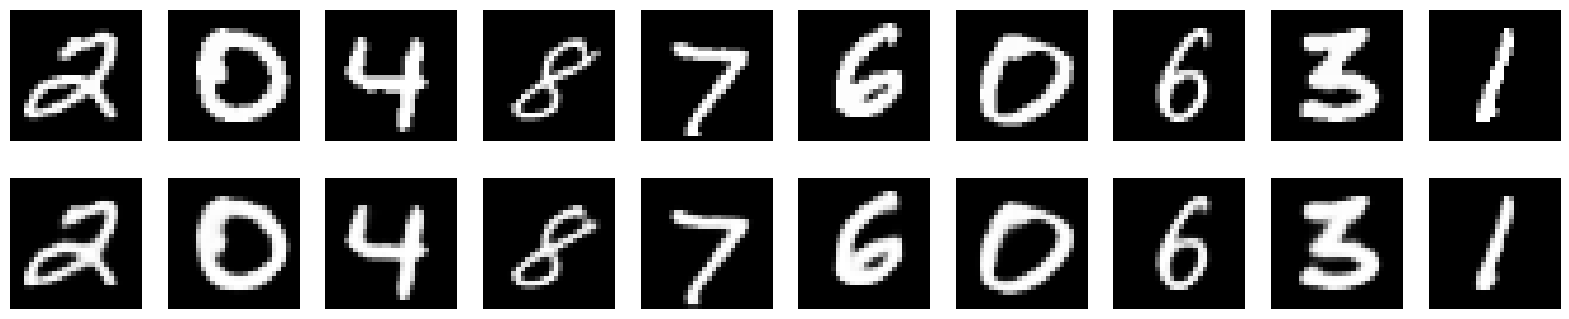

In [10]:
test_images = X_test.take(1).map(take_image).prefetch(tf.data.AUTOTUNE)
test_images = next(iter(test_images))
decoded_images = model.predict(test_images, verbose=0)
decoded_images = tf.clip_by_value(decoded_images, 0.0, 1.0)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].numpy().reshape(28, 28), cmap="gray")
    ax.axis("off")

    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_images[i].numpy().reshape(28, 28), cmap="gray")
    ax.axis("off")
plt.show()

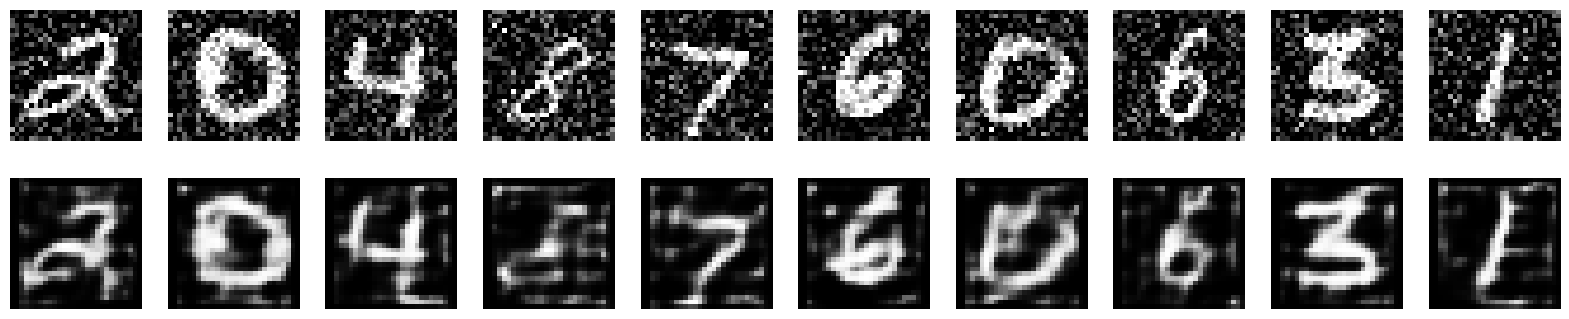

In [11]:
test_images_noisy = noisy(test_images, 0.3)
decoded_images_noisy = model.predict(test_images_noisy, verbose=0)
decoded_images_noisy = tf.clip_by_value(decoded_images_noisy, 0.0, 1.0)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    ax.axis("off")
    plt.imshow(test_images_noisy[i].numpy().reshape(28, 28), cmap="gray")

    ax = plt.subplot(2, n, i + n + 1)
    ax.axis("off")
    plt.imshow(decoded_images_noisy[i].numpy().reshape(28, 28), cmap="gray")
plt.show()